In [32]:
# Run in python console
import nltk;
#nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint
import progressbar
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,LsiModel,HdpModel,LdaMulticore
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
words= ['after', 'afterwards','again','against', 'all', 'almost','alone','along','already','also','although','always','am','among','amongst','amoungst','amount','an','and',
'another','any','anyhow','anyone','anything','anyway','anywhere','are','around','as','at','back','be','became','because','become','becomes','becoming','been','before',
'beforehand','behind','being','below','beside','besides','between','beyond','bill','both','bottom','but','by','call','can','cannot','cant','co','con','could','couldnt',
'cry','de','describe','detail','do','done','down','due','during','each','eg','eight','either','eleven','else','elsewhere','empty','enough','etc','even','ever','every',
'everyone','everything','everywhere','except','few','fifteen','fifty','fill','find','fire','first','five','for','former','formerly','forty','found','four','from','front',
'full','further','get','give','go','had','has','hasnt','have','he','hence','her','here','hereafter','hereby','herein','hereupon','hers','herself','him','himself','his',
'how','however','hundred','i','ie','if','in','inc','indeed','interest','into','is','it','its','itself','keep','last','latter','latterly','least','less','ltd','made','many',
'may','me','meanwhile','might','mill','mine','more','moreover','most','mostly','move','much','must','my','myself','name','namely','neither','never','nevertheless','next',
'nine','no','nobody','none','noone','nor','not','nothing','now','nowhere','of','off','often','on','once','one','only','onto','or','other','others','otherwise','our','ours',
'ourselves','out','over','own','part','per','perhaps','please','put','rather','re','same','see','seem','seemed','seeming','seems','serious','several','she','should','show',
'side','since','sincere','six','sixty','so','some','somehow','someone','something','sometime','sometimes','somewhere','still','such','system','take','ten','than','that',
'the','their','them','themselves','then','thence','there','thereafter','thereby','therefore','therein','thereupon','these','they','thick','thin','third','this','those','though',
'three','through','throughout','thru','thus','to','together','too','top','toward','towards','twelve','twenty','two','un','under','until','up','upon','us','very','via','was',
'we','well','were','what','whatever','when','whence','whenever','where','whereafter','whereas','whereby','wherein','whereupon','wherever','whether','which','while','whither',
'who','whoever','whole','whom','whose','why','will','with','within','without','would','yet','you','your','yours','yourself','yourselves']

In [33]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(words)

In [34]:
# Import Dataset
name ='ShireenMazari1_clean'

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 100)

df = pd.read_csv('dataset/'+name+'.csv',usecols=['text','lemmatized'],na_values='[]')
df[~df.lemmatized.str.len().eq(2)]
df= df.dropna()
df.head()

,text,lemmatized
0,Law Minister chairs CCLC - cabinet committee o...,"['law', 'minister', 'chair', 'cabinet', 'commi..."
1,Today CCLC approved 2 very critical bills: Jou...,"['approved', 'critical', 'journalist', 'protec..."
2,HR orgs incl HRW ask EU to call out India on i...,"['call', 'massive', 'human', 'right', 'violati..."
3,This is now becoming ridiculous and some ratio...,"['becoming', 'ridiculous', 'rationality', 'pre..."
4,On Labour Day we salute our workers who are th...,"['labour', 'salute', 'worker', 'backbone', 'co..."


In [35]:
data = df.lemmatized.values
text = df.text

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))



In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB'])

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('approval', 1),
  ('approve', 1),
  ('cabinet', 3),
  ('chair', 1),
  ('committee', 1),
  ('law', 1),
  ('legislation', 1),
  ('minister', 1),
  ('summary', 1)]]

In [72]:
limit=10; start=2; step=2;

# Latent Dirichlet Allocation (LDA)

In [73]:
def compute_coherence_values_LdaModel(dictionary, corpus, texts, limit, start=2, step=3):
    print('Running...')
    coherence_values = []
    model_list = []
    bar = progressbar.ProgressBar(max_value=limit)
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='auto',
                                               )
        bar.update(num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    print('Done')    
    return model_list, coherence_values

In [74]:
model_list_LDA, coherence_values_LDA = compute_coherence_values_LdaModel(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

Running...


 80% (8 of 10) |####################     | Elapsed Time: 0:02:01 ETA:   0:00:39

Done


# Latent Semantic Analysis (LSA)


In [75]:
def compute_coherence_values_LSA(dictionary, corpus, texts, limit, start=2, step=3):
    print('Running...')
    bar = progressbar.ProgressBar(max_value=limit)
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        bar.update(num_topics)
        
    print('Done.')    
    return model_list, coherence_values

In [76]:
model_list_LSI, coherence_values_LSI = compute_coherence_values_LSA(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

Running...


 80% (8 of 10) |####################     | Elapsed Time: 0:00:18 ETA:   0:00:06

Done.


# LdaMulticore

In [77]:
def compute_coherence_values_LDAM(dictionary, corpus, texts, limit, start=2, step=3):
    print('Running...')
    bar = progressbar.ProgressBar(max_value=limit)
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model= gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=1000,
                                           chunksize=1000,
                                           passes=10,
                                           #alpha=a,
                                           #eta=b
                                         )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        bar.update(num_topics)
    print('Done.')    
    return model_list, coherence_values

In [78]:
model_list_LDAM, coherence_values_LDAM = compute_coherence_values_LDAM(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

Running...


 80% (8 of 10) |####################     | Elapsed Time: 0:01:31 ETA:   0:00:27

Done.


# NMF with Word2Vec

In [79]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from sklearn import decomposition
from itertools import combinations


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

from gensim.models.fasttext import FastText

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = stop_words, min_df = 20) #custom_stop_words
A = vectorizer.fit_transform(df.lemmatized)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Created 20532 X 2030 document-term matrix
Vocabulary has 2030 distinct terms


In [81]:
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok.lower() in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok.lower() )
            yield tokens

In [82]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            #print(str(pair[0]) + " " + str(pair[1]))
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [83]:
topic_models = []
# try each value of k
for k in range(start, limit, step):
    print("Applying NMF for k=%d ..." % k )
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

Applying NMF for k=2 ...
Applying NMF for k=4 ...
Applying NMF for k=6 ...
Applying NMF for k=8 ...


In [84]:
docgen = TokenGenerator(df.lemmatized.values, stop_words)

# Coherences score with Word2Vec

In [85]:
w2v_model = gensim.models.Word2Vec(docgen, size=200, min_count=20, sg=1)
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        if(terms!=''):
            term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings))
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )


Building model ...
Building model ...
Building model ...
Building model ...
Building model ...
Building model ...
K=02: Coherence=0.6187
K=04: Coherence=0.6883
K=06: Coherence=0.7109
K=08: Coherence=0.6971


# Coherences score with FastText

In [86]:
fast_model = gensim.models.FastText(docgen, size=200, min_count=20, sg=1)

k_values = []
coherences_FAST = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        if(terms!=''):
            term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    
    k_values.append( k )
    coherences_FAST.append( calculate_coherence( fast_model, term_rankings))
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

Building model ...
Building model ...
Building model ...
Building model ...
Building model ...
Building model ...
K=02: Coherence=0.6971
K=04: Coherence=0.6971
K=06: Coherence=0.6971
K=08: Coherence=0.6971


# Comparision with different Models

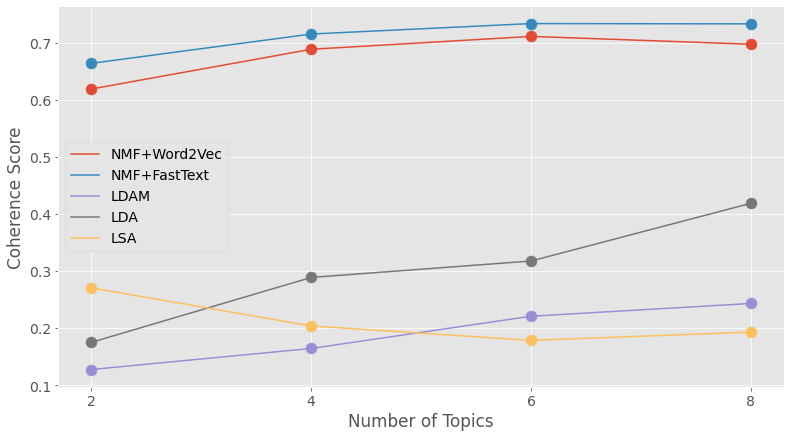

In [87]:
#fig = 
fig, ax = plt.subplots(figsize=(13,7))
# create the line plot
plt.plot(k_values, coherences,label="NMF+Word2Vec")
plt.plot(k_values, coherences_FAST,label="NMF+FastText")
plt.plot(k_values, coherence_values_LDAM, label="LDAM")
plt.plot(k_values, coherence_values_LDA, label="LDA")
plt.plot(k_values, coherence_values_LSI, label="LSA")
plt.legend(loc="center left")                
#ax.set_facecolor('silver')
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
# add the points
plt.scatter( k_values, coherences, s=120)
plt.scatter( k_values, coherences_FAST, s=120)
plt.scatter( k_values, coherence_values_LDAM, s=120)
plt.scatter( k_values, coherence_values_LDA, s=120)
plt.scatter( k_values, coherence_values_LSI, s=120)
# find and annotate the maximum point on the plot
plt.grid(True)

plt.savefig('comparision.eps', format='eps')
plt.savefig('comparision.png', format='png')
#plt.show()

In [68]:
Z = w2v_model.wv.vectors;
print('shape of word vector for Prince Harry {0}:'.format(Z.shape))


shape of word vector for Prince Harry (2089, 50):
[[ 0.09666158  0.19111826 -0.09163474 ...  0.38346058  0.26099458
   0.08705147]
 [-0.15761457  0.13555357 -0.02470147 ...  0.68159616  0.5517566
   0.05668474]
 [-0.4776111   0.01077374  0.4690781  ...  0.46074542 -0.5057357
   0.00165157]
 ...
 [-0.1267725   0.03643149 -0.01398549 ...  0.41829708  0.15012525
   0.18644428]
 [-0.02187914  0.16394208 -0.1326905  ...  0.39807603  0.24288735
   0.17870629]
 [-0.02912894  0.08735415 -0.11454633 ...  0.3862752   0.23141932
   0.17393059]]


In [62]:
### importing packages for K-Mean clustering and KDTree
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Initalize a k-means object and use it to extract centroids
def clustering_on_wordvecs(word_vectors, num_clusters):
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++')
    idx = kmeans_clustering.fit_predict(word_vectors)    
    return kmeans_clustering.cluster_centers_, idx


##Top K words on each cluster center.
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs)
    
    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers]
    closest_words_idxs = [x[1] for x in closest_points]

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {}
    for i in range(0, len(closest_words_idxs)):
        closest_words['Interest#' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words)
    df.index = df.index+1

    return df;

In [58]:
import pandas as pd
 
# intialise data of lists.
data = {'Model':['LDA', 'LADM', 'LSA', 'NMF+Word2Vec','NMF+FastText'],
        'Number of Topic':[30, 30, 30, 30,30],
        'Coherences Score':[.50, .38, .20, .72,.75],
       }
 
# Create DataFrame
dataf = pd.DataFrame(data)
 
# Print the output.
dataf.head()

,Model,Number of Topic,Coherences Score
0,LDA,30,0.50
1,LADM,30,0.38
2,LSA,30,0.20
3,NMF+Word2Vec,30,0.72
4,NMF+FastText,30,0.75


In [95]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(8):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Interests # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [100]:
print(model)

NMF(init='nndsvd', n_components=8)


,Interests # 01,Interests # 02,Interests # 03,Interests # 04,Interests # 05,Interests # 06,Interests # 07,Interests # 08
0,ik,indian,right,drone,woman,pakistan,state,law
1,know,occupation,human,attack,esp,team,terrorism,rule
2,abt,kashmiri,child,mly,abuse,vision,muslim,sc
3,party,force,abuse,killing,child,naya,world,child
4,need,modi,iok,ag,seat,make,ag,police
5,dont,iok,support,terror,violence,country,trump,order
6,ur,kashmir,constitution,shameful,shameful,people,israel,court
7,yes,medium,vote,strike,ag,let,esp,abuse
8,pol,world,mohr,war,party,great,israeli,constitution
9,medium,shameful,citizen,terrorist,vote,cricket,shameful,crime


In [102]:
from sklearn.metrics import cohen_kappa_score

In [104]:
y_true = [26, 6, 24, 0, 8, 20,7,23,16,10]
y_pred = [8, 7, 24, 0, 24, 20,3,1,16,10]
cohen_kappa_score(y_true, y_pred)

0.4565217391304347